# LOTR Network Notebook

This is a notebook to create a network relationship graph between characters in the Lord of the Rings books. It relies upon the scraped list of characters taken from <a href="https://www.scarymommy.com/lord-of-the-rings-names">here</a>. If there's a better list, then we should substitute that for the current list we're using. This code is inspired by <a href="https://github.com/thu-vu92/the_witcher_network">this repo</a> which used the Witcher book series to develop a relationship network graph.

## Import Libraries 

Import the required libraries, including functions defined by code in the repo, and load the English language model from the spacy library

In [128]:
import os
import json
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import community.community_louvain as community_louvain

NER = spacy.load("en_core_web_sm")

## Load the Books into the Environment

We'll now load the '.txt' files of the three books into our python environment. Then we'll check that they've been loaded correctly and look over the model analysis.

In [129]:
all_books = [b for b in os.scandir('Books') if '.txt' in b.name]

all_books

[<DirEntry '01 - The Fellowship Of The Ring.txt'>,
 <DirEntry '02 - The Two Towers.txt'>,
 <DirEntry '03 - The Return Of The King.txt'>]

In [132]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [133]:
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

## Load Character Names

Next we'll load the JSON list of character names into our environment. I have tried to edit these as much as possible, although this may need some tweaking going forward. 

We would also ideally have a 'book' category so we would be able to filter by book. However, I haven't been able to find a source for this we could use. 

Another issue is the presence of non-ASCII characters amongst the strings. Ideally they would be recorded in the list exactly how they are in the text files, so we may have to find character names and re-input them identically to how they are recorded in the book.



In [134]:
characters = json.loads(open('LOTR_characters.json', encoding="utf-8").read())
characters

['Aldor',
 'Anborn',
 'Angelica',
 'Angbor',
 'Aragorn',
 'Arwen',
 'Bilbo',
 'Frodo',
 'Balin',
 'Beechbone',
 'Bregalad',
 'Boromir',
 'Bruno',
 'Merry',
 'Mrs. Bracegirdle',
 'Melilot',
 'Carl Cotton',
 'Celeborn',
 'Cirdan',
 'Rosie',
 'Denethor',
 'Elendil',
 'Elrond',
 'Éomer',
 'Éomund',
 'Éothain',
 'Éowyn',
 'Faramir',
 'Fastred',
 'Finglas',
 'Filibert Bolger',
 'Fladrif',
 'Fredegar Bolger',
 'Galadriel',
 'Sam',
 'Gandalf',
 'Gimli',
 'Gleowine',
 'Gollum',
 'Wormtongue',
 'Hamfast',
 'Isildur',
 'Khamûl',
 'Legolas',
 'Nazgul',
 'Farmer Maggot',
 'Saruman',
 'Shelob',
 'Pippin',
 'Treebeard',
 'Old Noakes',
 'Mrs. Proudfoot',
 'Odo Proudfoot',
 'Otho Sackville-Baggins',
 'Lobelia Sackville-Baggins',
 'Ted Sandyman',
 'Diamond Took',
 'Bard the Bowman',
 'Barliman Butterbur',
 'Arwen',
 'Figwit',
 'Forlong',
 'Elrond',
 'Erestor',
 'Nestadion',
 'Silinde',
 'Celeborn',
 'Galadriel',
 'Haldir',
 'Nilfaleth',
 'Rúmil',
 'Damrod',
 'Denethor',
 'Eldarion',
 'Elendil',
 'Farami

## Sentence Entity Data Frame

The next thing we'll need to do is begin to develop our entity-by-sentence data frame. This will serve as the beginnings of our network data. <b>This will take some time to run</b>.

In [135]:
sent_entity_df = []

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [136]:
sent_entity_df.head(50)

,sentence,entities
0,"( , THE, TWO, TOWERS, \n\n ...","[TWO, SECOND, Rings, Chapter 1]"
1,"(Every, now, and, again, he, bent, to, the, gr...",[]
2,"(Hobbits, go, light, ,, and, their, footprints...",[]
3,"(\n , ', I, read, the, signs, aright, ,, '...",[]
4,"(', Frodo, ran, to, the, hill, -, top, .)",[]
5,"(I, wonder, what, he, saw, there, ?)",[]
6,"(But, he, returned, by, the, same, way, ,, and...",[]
7,"(He, desired, to, go, to, the, high, seat, him...",[]
8,"(Suddenly, he, leaped, forward, ,, and, ran, t...",[]
9,"(Then, sitting, in, the, high, seat, he, looke...",[]


## Converting to a Character to Character Data Frame

With this, we can then filter out the non-character entities using the json character list that we loaded earlier. We'll define a function for this purpose and then filter the resultant data frame to produce a character-to-character relationship data frame.

In [137]:
def filter_entity(ent_list, characters):
    return [ent for ent in ent_list 
            if ent in list(characters)]

In [138]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters))

sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
16,"(\n , ', The, horn, of, Boromir, !, ')",[Boromir],[Boromir]
22,"(Where, is, Sam, ?, ', \n , As, he, ran, t...",[Sam],[Sam]
27,"(\n , A, mile, ,, maybe, ,, from, Parth, G...","[Parth Galen, Boromir]",[Boromir]
32,"(Boromir, opened, his, eyes, and, strove, to, ...",[Boromir],[Boromir]
43,"(\n , ', Farewell, ,, Aragorn, !)",[Aragorn],[Aragorn]
45,"(I, have, failed, ., ', \n , ', No, !, ', ...",[Aragorn],[Aragorn]
49,"(Minas, Tirith, shall, not, fall, !, ', \n ...","[Minas Tirith, Boromir]",[Boromir]
52,"(said, Aragorn, .)",[Aragorn],[Aragorn]
53,"(\n , But, Boromir, did, not, speak, again...",[Boromir],[Boromir]
54,"(\n , ', Alas, !, ', said, Aragorn, ., ')",[Aragorn],[Aragorn]


In [139]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [140]:
relationship_df = pd.DataFrame(relationships)

In [141]:
relationship_df.head(10)

,source,target
0,Sam,Boromir
1,Aragorn,Boromir
2,Aragorn,Boromir
3,Boromir,Aragorn
4,Boromir,Aragorn
5,Aragorn,Boromir
6,Boromir,Aragorn
7,Aragorn,Boromir
8,Boromir,Aragorn
9,Aragorn,Boromir


In [142]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

relationship_df.head(10)

,source,target,value
0,Sam,Boromir,13
1,Aragorn,Boromir,48
2,Boromir,Aragorn,41
3,Aragorn,Denethor,14
4,Denethor,Gandalf,2
5,Gandalf,Boromir,16
6,Boromir,Legolas,18
7,Legolas,Gimli,186
8,Gimli,Legolas,207
9,Legolas,Aragorn,143


## Create Graph and Community Visualisation

With this data, we can now undertake our graph analysis and build some graph visualisations.

In [143]:
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

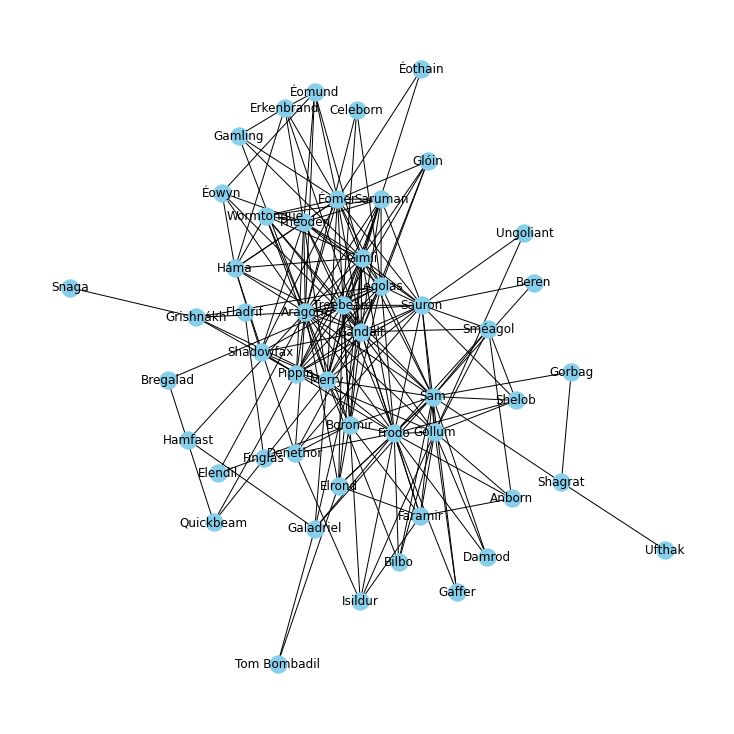

In [144]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [145]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("tt.html")

In [146]:
communities_tt = community_louvain.best_partition(G)
communities_tt

{'Sam': 0,
 'Boromir': 0,
 'Aragorn': 1,
 'Denethor': 0,
 'Gandalf': 1,
 'Legolas': 4,
 'Gimli': 1,
 'Frodo': 0,
 'Sauron': 0,
 'Saruman': 1,
 'Pippin': 4,
 'Éomund': 1,
 'Éomer': 1,
 'Éothain': 1,
 'Théoden': 1,
 'Celeborn': 4,
 'Elrond': 0,
 'Merry': 4,
 'Grishnákh': 4,
 'Snaga': 4,
 'Shadowfax': 4,
 'Gollum': 0,
 'Bilbo': 0,
 'Treebeard': 4,
 'Tom Bombadil': 2,
 'Galadriel': 2,
 'Fladrif': 3,
 'Finglas': 3,
 'Bregalad': 4,
 'Quickbeam': 4,
 'Glóin': 1,
 'Wormtongue': 1,
 'Háma': 1,
 'Elendil': 0,
 'Éowyn': 1,
 'Erkenbrand': 1,
 'Gamling': 1,
 'Sméagol': 0,
 'Gaffer': 0,
 'Isildur': 0,
 'Hamfast': 2,
 'Faramir': 0,
 'Damrod': 0,
 'Anborn': 0,
 'Shelob': 0,
 'Beren': 0,
 'Ungoliant': 0,
 'Shagrat': 0,
 'Gorbag': 0,
 'Ufthak': 0}

In [147]:
nx.set_node_attributes(G, communities_tt, 'group')
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("tt_communities.html")

## Most Important Characters in the Two Towers

Finally, we'll start conducting some analysis using just the relationships from the Two Towers. Specifically, we'll want to investigate how important characters are according to the follwing measures of centrality:

* Degree Centrality: Which nodes have the most connections?
* Betweenness Centrality: Which nodes are the best "bridges" between groups of nodes?
* Closeness Centrality: Which nodes would be best to spread information to other nodes?

We will take the results from this and turn them into csv files for visualisation in R later.


<b>Degree Centrality</b>

In [74]:
degree_dict = nx.degree_centrality(G)

degree_dict

{'Sam': 0.42857142857142855,
 'Boromir': 0.2857142857142857,
 'Aragorn': 0.5102040816326531,
 'Denethor': 0.14285714285714285,
 'Gandalf': 0.4897959183673469,
 'Legolas': 0.3469387755102041,
 'Gimli': 0.4081632653061224,
 'Frodo': 0.44897959183673464,
 'Sauron': 0.36734693877551017,
 'Saruman': 0.22448979591836732,
 'Pippin': 0.26530612244897955,
 'Éomund': 0.12244897959183673,
 'Éomer': 0.3469387755102041,
 'Éothain': 0.04081632653061224,
 'Théoden': 0.32653061224489793,
 'Celeborn': 0.061224489795918366,
 'Elrond': 0.16326530612244897,
 'Merry': 0.3877551020408163,
 'Grishnákh': 0.1020408163265306,
 'Snaga': 0.02040816326530612,
 'Shadowfax': 0.16326530612244897,
 'Gollum': 0.3061224489795918,
 'Bilbo': 0.08163265306122448,
 'Treebeard': 0.3469387755102041,
 'Tom Bombadil': 0.04081632653061224,
 'Galadriel': 0.12244897959183673,
 'Fladrif': 0.02040816326530612,
 'Finglas': 0.02040816326530612,
 'Bregalad': 0.04081632653061224,
 'Quickbeam': 0.061224489795918366,
 'Glóin': 0.102040816

In [75]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

degree_df.to_csv('Centrality Measures TT/Centrality.csv')

<b>Betweeness Centrality</b>

In [76]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_dict

{'Sam': 0.1787258249573439,
 'Boromir': 0.029105083347142017,
 'Aragorn': 0.15760381331201762,
 'Denethor': 0.004558278037044543,
 'Gandalf': 0.09116408951046755,
 'Legolas': 0.03378557091802258,
 'Gimli': 0.06484252433688126,
 'Frodo': 0.09644048571020672,
 'Sauron': 0.06379391884827612,
 'Saruman': 0.0007676469411163289,
 'Pippin': 0.02324088806030266,
 'Éomund': 0.0015222958059961282,
 'Éomer': 0.03203454092332671,
 'Éothain': 0.0,
 'Théoden': 0.01634377466233235,
 'Celeborn': 0.0,
 'Elrond': 0.024010467282150956,
 'Merry': 0.0669552128868092,
 'Grishnákh': 0.0391156462585034,
 'Snaga': 0.0,
 'Shadowfax': 0.0018940209751402645,
 'Gollum': 0.05061092632015737,
 'Bilbo': 0.00012147716229348882,
 'Treebeard': 0.05804516059539118,
 'Tom Bombadil': 0.00028344671201814054,
 'Galadriel': 0.021992351233422667,
 'Fladrif': 0.0,
 'Finglas': 0.0,
 'Bregalad': 0.0005749919015225138,
 'Quickbeam': 0.0022048104956268223,
 'Glóin': 0.0001481653267367553,
 'Wormtongue': 0.0008723835854688195,
 'Hám

In [77]:
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.to_csv('Centrality Measures TT/Betweenness.csv')

<b>Closeness Centrality</b>

In [78]:
closeness_dict = nx.closeness_centrality(G)
closeness_dict

{'Sam': 0.6092112520683949,
 'Boromir': 0.5431522006392919,
 'Aragorn': 0.6440233236151602,
 'Denethor': 0.4696003401360544,
 'Gandalf': 0.6261337868480725,
 'Legolas': 0.5706535778868509,
 'Gimli': 0.5931793770139635,
 'Frodo': 0.6092112520683949,
 'Sauron': 0.5706535778868509,
 'Saruman': 0.4847487382049594,
 'Pippin': 0.5242050308495491,
 'Éomund': 0.4213236696547778,
 'Éomer': 0.5181796856673704,
 'Éothain': 0.3788372491853884,
 'Théoden': 0.512291280148423,
 'Celeborn': 0.40614083471226325,
 'Elrond': 0.49540255662704646,
 'Merry': 0.5931793770139635,
 'Grishnákh': 0.42529842125529455,
 'Snaga': 0.29658968850698175,
 'Shadowfax': 0.46475909951609506,
 'Gollum': 0.5366861030126336,
 'Bilbo': 0.4334772370486656,
 'Treebeard': 0.5706535778868509,
 'Tom Bombadil': 0.34678178963893247,
 'Galadriel': 0.46475909951609506,
 'Fladrif': 0.02040816326530612,
 'Finglas': 0.02040816326530612,
 'Bregalad': 0.3665173386427742,
 'Quickbeam': 0.38204773434797645,
 'Glóin': 0.42529842125529455,
 'W

In [79]:
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])

closeness_df.to_csv('Centrality Measures TT/Closeness.csv')

## Combining the Books Together

Finally, with this analysis, we can move onto analysing the books altogether. First we'll define the functions necessary to work with this data, then we'll run the model on the books.

<b>Note:</b> This will take some time to run, and we've had to increase the max length defined by the model as the length of the books is too large.


In [99]:
def ner(file_name):
   
    nlp = spacy.load("en_core_web_sm")
    nlp.max_length = 1500000
    book_text = open(file_name).read()
    book_doc = nlp(book_text)
    
    return book_doc


def get_ne_list_per_sentence(spacy_doc):
    
    sent_entity_df = []

    for sent in spacy_doc.sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})

    sent_entity_df = pd.DataFrame(sent_entity_df)
    
    return sent_entity_df


def filter_entity(ent_list, characters):
    
    return [ent for ent in ent_list 
            if ent in characters 
            or ent in characters
           ]


def create_relationships(df, window_size):
   
    relationships = []

    for i in range(df.index[-1]):
        end_i = min(i+5, df.index[-1])
        char_list = sum((df.loc[i: end_i].character_entities), [])

        char_unique = [char_list[i] for i in range(len(char_list)) 
                       if (i==0) or char_list[i] != char_list[i-1]]

        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
           
    relationship_df = pd.DataFrame(relationships)
    # Sort the cases with a->b and b->a
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), 
                                   columns = relationship_df.columns)
    relationship_df["value"] = 1
    relationship_df = relationship_df.groupby(["source","target"], 
                                              sort=False, 
                                              as_index=False).sum()
                
    return relationship_df


In [100]:
books_graph = []
all_books = [b for b in os.scandir('Books') if '.txt' in b.name]

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1500000

all_books.sort(key=lambda x: x.name)

In [101]:
for book in all_books:
    book_text = ner(book)

    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters))

    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

C:\Users\payne\AppData\Local\Temp\ipykernel_4412\1665915770.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Users\payne\AppData\Local\Temp\ipykernel_4412\1665915770.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Users\payne\AppData\Local\Tem

## The One Relationship Diagram to Rule Them All

Now we have the final relationship dataframe for the combined books, we can then visualise this network in the same way that we did earlier.

* Initial graph
* Dynamic graph
* Visualise communities

In [108]:
G_all = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

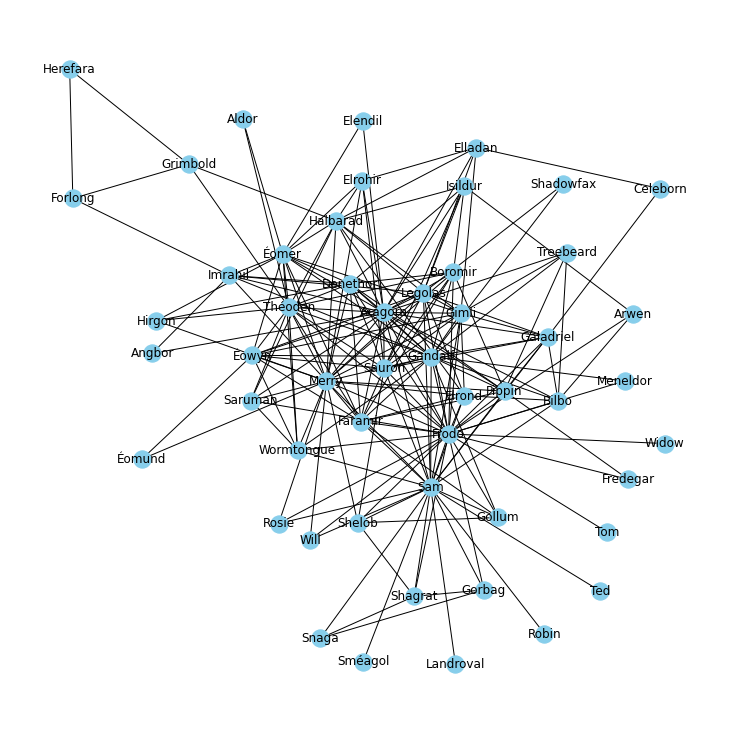

In [109]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G_all)
nx.draw(G_all, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [110]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G_all.degree)

#Setting up node size attribute
nx.set_node_attributes(G_all, node_degree, 'size')

net.from_nx(G_all)
net.show("lotr.html")

In [113]:
communities = community_louvain.best_partition(G_all)
communities

{'Gandalf': 1,
 'Pippin': 1,
 'Frodo': 0,
 'Denethor': 1,
 'Boromir': 1,
 'Théoden': 3,
 'Aragorn': 1,
 'Treebeard': 1,
 'Isildur': 1,
 'Faramir': 1,
 'Merry': 3,
 'Legolas': 4,
 'Gimli': 4,
 'Halbarad': 4,
 'Saruman': 3,
 'Elladan': 4,
 'Elrohir': 4,
 'Galadriel': 4,
 'Éomer': 3,
 'Elrond': 4,
 'Sauron': 1,
 'Éowyn': 3,
 'Sam': 0,
 'Wormtongue': 3,
 'Hirgon': 3,
 'Gollum': 0,
 'Éomund': 3,
 'Arwen': 1,
 'Imrahil': 2,
 'Forlong': 2,
 'Grimbold': 2,
 'Herefara': 2,
 'Elendil': 3,
 'Angbor': 2,
 'Shelob': 0,
 'Shagrat': 0,
 'Gorbag': 0,
 'Snaga': 0,
 'Bilbo': 1,
 'Rosie': 0,
 'Sméagol': 0,
 'Meneldor': 1,
 'Landroval': 0,
 'Celeborn': 4,
 'Shadowfax': 1,
 'Aldor': 3,
 'Robin': 0,
 'Will': 0,
 'Tom': 0,
 'Ted': 0,
 'Fredegar': 0,
 'Widow': 0}

In [114]:
nx.set_node_attributes(G_all, communities, 'group')
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G_all)
com_net.show("lotr_communities.html")

## Most Important Characters in the Combined Books

Next, we will emply the same centrality measures that we employed earlier to get an overall sense of how important each character is in the combined series.

In [119]:
degree_dict = nx.degree_centrality(G_all)

degree_dict

{'Gandalf': 0.4117647058823529,
 'Pippin': 0.21568627450980393,
 'Frodo': 0.5490196078431373,
 'Denethor': 0.2549019607843137,
 'Boromir': 0.19607843137254902,
 'Théoden': 0.3137254901960784,
 'Aragorn': 0.49019607843137253,
 'Treebeard': 0.09803921568627451,
 'Isildur': 0.13725490196078433,
 'Faramir': 0.27450980392156865,
 'Merry': 0.47058823529411764,
 'Legolas': 0.27450980392156865,
 'Gimli': 0.27450980392156865,
 'Halbarad': 0.23529411764705882,
 'Saruman': 0.11764705882352941,
 'Elladan': 0.11764705882352941,
 'Elrohir': 0.11764705882352941,
 'Galadriel': 0.19607843137254902,
 'Éomer': 0.29411764705882354,
 'Elrond': 0.1568627450980392,
 'Sauron': 0.29411764705882354,
 'Éowyn': 0.21568627450980393,
 'Sam': 0.47058823529411764,
 'Wormtongue': 0.1568627450980392,
 'Hirgon': 0.0784313725490196,
 'Gollum': 0.09803921568627451,
 'Éomund': 0.0392156862745098,
 'Arwen': 0.058823529411764705,
 'Imrahil': 0.1568627450980392,
 'Forlong': 0.058823529411764705,
 'Grimbold': 0.078431372549019

In [120]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

degree_df.to_csv('Centrality Measures All/Centrality.csv')

In [121]:
betweenness_dict = nx.betweenness_centrality(G_all)
betweenness_dict

{'Gandalf': 0.08105549667831413,
 'Pippin': 0.016193108990871893,
 'Frodo': 0.22768421130236452,
 'Denethor': 0.014633813368258594,
 'Boromir': 0.0029915510731450008,
 'Théoden': 0.07707061540134463,
 'Aragorn': 0.1354822133232058,
 'Treebeard': 0.0003548085901027077,
 'Isildur': 0.0066030309559721315,
 'Faramir': 0.014288773440353501,
 'Merry': 0.11723564965892656,
 'Legolas': 0.04141218474430619,
 'Gimli': 0.022671303859653495,
 'Halbarad': 0.03378678644428171,
 'Saruman': 0.001129811056797279,
 'Elladan': 0.010425944847197218,
 'Elrohir': 0.001837676554944107,
 'Galadriel': 0.029382022784299824,
 'Éomer': 0.03411322829856996,
 'Elrond': 0.00422711923862819,
 'Sauron': 0.023604601250532136,
 'Éowyn': 0.009956678503168066,
 'Sam': 0.22853029043620166,
 'Wormtongue': 0.006291389276728923,
 'Hirgon': 0.0,
 'Gollum': 0.0004444444444444444,
 'Éomund': 0.0,
 'Arwen': 0.001296386655020431,
 'Imrahil': 0.044334132098837985,
 'Forlong': 0.008548205607029133,
 'Grimbold': 0.03617669041198452,


In [122]:
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.to_csv('Centrality Measures All/Betweenness.csv')

In [123]:
closeness_dict = nx.closeness_centrality(G_all)
closeness_dict

{'Gandalf': 0.6219512195121951,
 'Pippin': 0.53125,
 'Frodo': 0.6710526315789473,
 'Denethor': 0.53125,
 'Boromir': 0.51,
 'Théoden': 0.5543478260869565,
 'Aragorn': 0.6538461538461539,
 'Treebeard': 0.4358974358974359,
 'Isildur': 0.4434782608695652,
 'Faramir': 0.5604395604395604,
 'Merry': 0.6375,
 'Legolas': 0.5666666666666667,
 'Gimli': 0.5666666666666667,
 'Halbarad': 0.5,
 'Saruman': 0.4857142857142857,
 'Elladan': 0.4322033898305085,
 'Elrohir': 0.45535714285714285,
 'Galadriel': 0.5151515151515151,
 'Éomer': 0.51,
 'Elrond': 0.51,
 'Sauron': 0.5730337078651685,
 'Éowyn': 0.4857142857142857,
 'Sam': 0.6144578313253012,
 'Wormtongue': 0.51,
 'Hirgon': 0.4214876033057851,
 'Gollum': 0.4594594594594595,
 'Éomund': 0.3984375,
 'Arwen': 0.4214876033057851,
 'Imrahil': 0.4811320754716981,
 'Forlong': 0.34,
 'Grimbold': 0.3953488372093023,
 'Herefara': 0.2897727272727273,
 'Elendil': 0.4112903225806452,
 'Angbor': 0.408,
 'Shelob': 0.4766355140186916,
 'Shagrat': 0.4358974358974359,
 

In [124]:
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])

closeness_df.to_csv('Centrality Measures All/Closeness.csv')

## Evolution of Importance

With a dataframe of all the books we can then see how the importance (here measured through centrality) of each character evolves over the course of the books.

In [105]:
evol = [nx.degree_centrality(book) for book in books_graph]

degree_evol_df = pd.DataFrame.from_records(evol)
degree_evol_df

,Balin,Gandalf,Frodo,Bilbo,Thorin,Gollum,Elrond,Sauron,Celeborn,Galadriel,...,Forlong,Grimbold,Herefara,Angbor,Rosie,Meneldor,Landroval,Aldor,Robin,Widow
0,0.24,0.400000,0.68000,0.340000,0.06,0.260000,0.460000,0.340000,0.240000,0.140000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.489796,0.44898,0.081633,NaN,0.306122,0.163265,0.367347,0.061224,0.122449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.411765,0.54902,0.156863,NaN,0.098039,0.156863,0.294118,0.039216,0.196078,...,0.058824,0.078431,0.039216,0.039216,0.058824,0.039216,0.019608,0.039216,0.019608,0.019608


In [106]:
degree_evol_df.to_csv('Centrality Measures All/Importance.csv')